In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split
import kagglehub as kh
from sklearn.metrics import confusion_matrix

NORMALIZE_COUNTS = True

In [119]:
path = kh.dataset_download("uciml/msd-audio-features")
print("Path to dataset files:", path)
data_by_decade = pd.read_csv(path + "/year_prediction.csv")
# data_by_ear doesn't have the year labels squashed into decades
data_by_year = pd.read_csv(path + "/year_prediction.csv")

# check for NA
data_dropped = data_by_decade.dropna()
if len(data_dropped) == len(data_by_decade):
    print("No NA")

def convert_year(year):
    year_str = str(int(year["label"]))
    year_str = year_str[:-1] + '0'
    year_str += 's'
    return year_str

data_by_decade["label"] = data_by_decade.apply(convert_year, axis=1)

labels_trim = data_by_decade["label"]
labels_trim = labels_trim.replace({"2010s": "2000s"})
labels_trim = labels_trim.replace({"2000s": "2000s"})
labels_trim = labels_trim.replace({"1990s": "1990s"})
labels_trim = labels_trim.replace({"1980s": "1980s"})
labels_trim = labels_trim.replace({"1970s": "1970s"})
labels_trim = labels_trim.replace({"1960s": "<=1960s"})
labels_trim = labels_trim.replace({"1950s":  "<=1960s"})
labels_trim = labels_trim.replace({"1940s": "<=1960s"})
labels_trim = labels_trim.replace({"1930s":  "<=1960s"})
labels_trim = labels_trim.replace({"1920s":  "<=1960s"})
data_by_decade["label"] = labels_trim

data_by_decade, test_big = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])

if NORMALIZE_COUNTS:
    min_count = data_by_decade['label'].value_counts().min()
    data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)

X = data_by_decade.drop(columns=[ "label"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_by_decade = pd.concat([pd.DataFrame(data_by_decade["label"]), pd.DataFrame(X_scaled, columns=X.columns)], axis=1)

data_by_decade["label"].value_counts()

Path to dataset files: /home/koris/.cache/kagglehub/datasets/uciml/msd-audio-features/versions/1
No NA


/tmp/ipykernel_247023/1641541845.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_by_decade = data_by_decade.groupby('label').apply(lambda x: x.sample(min_count, replace=True)).reset_index(drop=True)


label
1970s      10971
1980s      10971
1990s      10971
2000s      10971
<=1960s    10971
Name: count, dtype: int64

In [107]:
from sklearn.metrics import r2_score

def adjr2(pred, test, p):
    r2 = r2_score(test, pred)
    n = len(test)
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [108]:
avg_cols = [f'TimbreAvg{i}' for i in range(1, 13)]
cov_cols = [f'TimbreCovariance{i}' for i in range(1, 79)]
feature_cols = avg_cols + cov_cols

data_by_decade["label"] = data_by_decade["label"].astype("category")
label_lookup = dict(enumerate(data_by_decade['label'].cat.categories))
train, test = train_test_split(data_by_decade, train_size=0.7, random_state=42, stratify=data_by_decade["label"])
test_lookup = dict(enumerate(test['label'].cat.categories))
train_lookup = dict(enumerate(train['label'].cat.categories))
train["label"] = train["label"].cat.codes
test["label"] = test["label"].cat.codes
assert test_lookup == train_lookup
assert test_lookup == label_lookup

test_label = test["label"].astype("category").cat.codes
train_label = train["label"].astype("category").cat.codes
test.drop("label", axis=1, inplace=True)
train.drop("label", axis=1, inplace=True)

og_cat_test = test.copy()
og_cat_test_label = test_label.copy()

### CatBoost Training (full)

Learning rate set to 0.146921
0:	learn: 1.5735685	total: 10.1ms	remaining: 10.1s
1:	learn: 1.5461724	total: 17.6ms	remaining: 8.79s
2:	learn: 1.5245326	total: 25.7ms	remaining: 8.55s
3:	learn: 1.5045607	total: 33.6ms	remaining: 8.38s
4:	learn: 1.4865901	total: 41.9ms	remaining: 8.34s
5:	learn: 1.4730649	total: 49.3ms	remaining: 8.17s
6:	learn: 1.4598330	total: 57.6ms	remaining: 8.17s
7:	learn: 1.4478557	total: 65ms	remaining: 8.07s
8:	learn: 1.4372381	total: 73.9ms	remaining: 8.14s
9:	learn: 1.4283261	total: 81.3ms	remaining: 8.05s
10:	learn: 1.4198207	total: 90.9ms	remaining: 8.17s
11:	learn: 1.4118310	total: 98.5ms	remaining: 8.11s
12:	learn: 1.4033804	total: 107ms	remaining: 8.11s
13:	learn: 1.3965964	total: 114ms	remaining: 8.06s
14:	learn: 1.3893889	total: 124ms	remaining: 8.13s
15:	learn: 1.3829766	total: 131ms	remaining: 8.06s
16:	learn: 1.3759485	total: 140ms	remaining: 8.07s
17:	learn: 1.3704271	total: 147ms	remaining: 8.01s
18:	learn: 1.3645033	total: 155ms	remaining: 8.02s
1

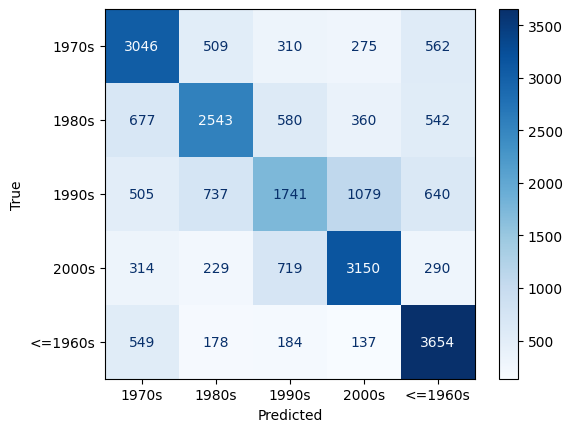

In [109]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

# CATBOOST ACCURACY
pred = cat_model.predict(test)
test_label_list = test_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
print(adjr2(test_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Multinom Training (full)

/home/koris/Documents/GitHub/MusicAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.4969374734155678
0.16841893920172213


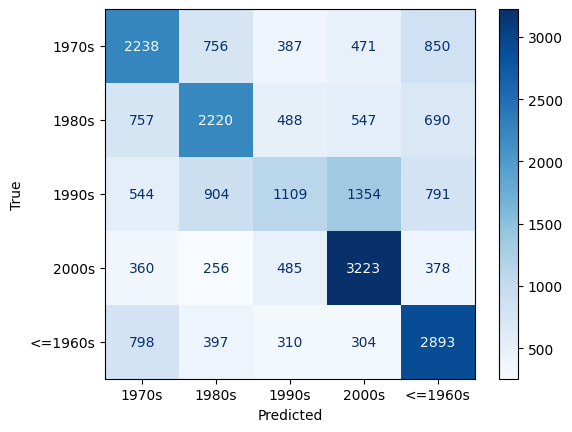

In [110]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train, train_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test)

correct = 0
for i, label in enumerate(test_label):
    if label == multi_preds[i]:
        correct += 1

acc = correct / len(test_label)
print(acc)
print(adjr2(test_label, pred, len(train.columns) - 1))
# confusion matrix
matrix = confusion_matrix(test_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### Multinom Reduced

In [111]:
# sample down
df_sample = data_by_decade
if len (data_by_decade) > 100000:
    df_sample =  train_test_split(data_by_decade, train_size=(100000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
else:
    df_sample =  train_test_split(data_by_decade, train_size=(10000 / len(data_by_decade)), random_state=42, stratify=data_by_decade["label"])
df_sample = pd.DataFrame(df_sample[0], columns=data_by_decade.columns)

sample_train, sample_test = train_test_split(df_sample, train_size=0.7, random_state=42, stratify=df_sample["label"])

sample_test_label = sample_test["label"].astype("category").cat.codes
sample_train_label = sample_train["label"].astype("category").cat.codes
sample_test.drop("label", axis=1, inplace=True)
sample_train.drop("label", axis=1, inplace=True)


In [112]:
# ___________Find Best Alpha___________
param_grid = {'alpha': np.linspace(0.01, 1, 25)} 
grid_search = GridSearchCV(Lasso(), param_grid, cv=5)
grid_search.fit(sample_train, sample_train_label)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

# Fit the model with the best alpha
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(sample_train, sample_train_label)

# Evaluate the performance on the test set
test_score = lasso_best.score(sample_test, sample_test_label)

print(f"Best alpha from GridSearchCV: {best_alpha}")
print(f"Best cross-validation score: {best_score}")
print(f"Test R^2 score: {test_score}")


# ___________Apply Best Alpha___________

lasso = Lasso(alpha=best_alpha, random_state=1)
lasso.fit(sample_train, sample_train_label)

coef = pd.Series(lasso.coef_, index=feature_cols)
selected_features = coef[coef != 0]

# Sort by the absolute value but retain the original sign
sorted_by_abs_value = selected_features.reindex(selected_features.abs().sort_values(ascending=False).index)

num_features = len(sorted_by_abs_value)
print(f"\n{num_features} Selected Features by LASSO (sorted by absolute value):")
print(sorted_by_abs_value)


Best alpha from GridSearchCV: 0.01
Best cross-validation score: 0.1245192076822433
Test R^2 score: 0.09491106792524262

62 Selected Features by LASSO (sorted by absolute value):
TimbreAvg1            0.280159
TimbreAvg2           -0.237869
TimbreAvg11          -0.188329
TimbreCovariance46    0.123670
TimbreCovariance1    -0.120322
                        ...   
TimbreCovariance21    0.001680
TimbreCovariance77    0.000806
TimbreCovariance19   -0.000625
TimbreAvg5           -0.000375
TimbreCovariance11    0.000353
Length: 62, dtype: float64


In [113]:
reduced_features = sorted_by_abs_value.index.to_list()
data_by_decade_reduced = data_by_decade.drop(columns=reduced_features)


train_reduced, test_reduced = train_test_split(data_by_decade_reduced, train_size=0.7, random_state=42, stratify=data_by_decade_reduced["label"])

test_reduced_label = test_reduced["label"].astype("category").cat.codes
train_reduced_label = train_reduced["label"].astype("category").cat.codes
test_reduced.drop("label", axis=1, inplace=True)
train_reduced.drop("label", axis=1, inplace=True)

/home/koris/Documents/GitHub/MusicAnalysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.16841893920172213


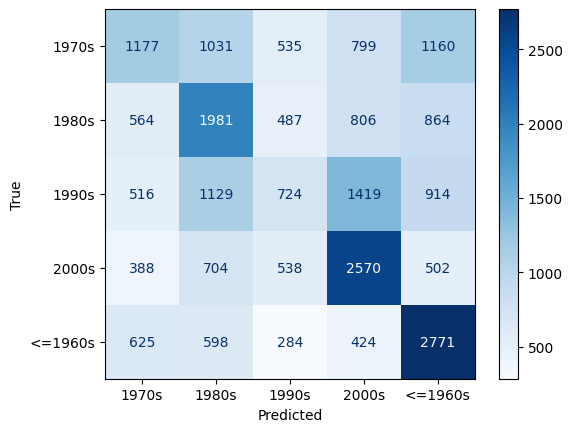

In [114]:
multinomial_model = LogisticRegression(multi_class='multinomial')
multi_res = multinomial_model.fit(train_reduced, train_reduced_label)

# MULTINOMIAL ACCURACY
multi_preds = multi_res.predict(test_reduced)

correct = 0
for i, label in enumerate(test_reduced_label):
    if label == multi_preds[i]:
        correct += 1

correct / len(test_label)
print(adjr2(test_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_reduced_label, multi_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

### CatBoost Reduced

In [122]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train, train_label)

Learning rate set to 0.146921
0:	learn: 1.5735685	total: 12.2ms	remaining: 12.2s
1:	learn: 1.5461724	total: 20.6ms	remaining: 10.3s
2:	learn: 1.5245327	total: 29.6ms	remaining: 9.85s
3:	learn: 1.5045605	total: 38.8ms	remaining: 9.65s
4:	learn: 1.4865902	total: 48ms	remaining: 9.55s
5:	learn: 1.4730646	total: 56ms	remaining: 9.27s
6:	learn: 1.4598336	total: 65.2ms	remaining: 9.25s
7:	learn: 1.4478557	total: 73ms	remaining: 9.06s
8:	learn: 1.4372379	total: 81.9ms	remaining: 9.02s
9:	learn: 1.4283260	total: 91.4ms	remaining: 9.05s
10:	learn: 1.4198209	total: 100ms	remaining: 9s
11:	learn: 1.4118310	total: 111ms	remaining: 9.16s
12:	learn: 1.4033805	total: 119ms	remaining: 9.02s
13:	learn: 1.3965963	total: 127ms	remaining: 8.97s
14:	learn: 1.3893888	total: 137ms	remaining: 8.97s
15:	learn: 1.3829769	total: 145ms	remaining: 8.91s
16:	learn: 1.3759487	total: 155ms	remaining: 8.95s
17:	learn: 1.3704271	total: 163ms	remaining: 8.92s
18:	learn: 1.3645034	total: 171ms	remaining: 8.83s
19:	learn:

In [123]:
cat_res.feature_names_
cat_res.feature_importances_
sorted_importances = sorted(zip(cat_res.feature_names_, cat_res.feature_importances_), key=lambda x: x[1], reverse=True)
sorted_importances

top = sorted_importances[:70]
top_names = [x[0] for x in top]

top_names
remaining_names = [x for x in cat_res.feature_names_ if x not in top_names]
remaining_names

['TimbreCovariance6',
 'TimbreCovariance18',
 'TimbreCovariance19',
 'TimbreCovariance20',
 'TimbreCovariance21',
 'TimbreCovariance22',
 'TimbreCovariance23',
 'TimbreCovariance30',
 'TimbreCovariance32',
 'TimbreCovariance33',
 'TimbreCovariance39',
 'TimbreCovariance42',
 'TimbreCovariance49',
 'TimbreCovariance52',
 'TimbreCovariance54',
 'TimbreCovariance60',
 'TimbreCovariance63',
 'TimbreCovariance65',
 'TimbreCovariance75',
 'TimbreCovariance78']

In [126]:
data_by_decade_reduced_by_importance = data_by_decade.drop(columns=remaining_names)


train_reduced_by_importance, test_reduced_by_importance = train_test_split(data_by_decade_reduced_by_importance, train_size=0.7, random_state=42, stratify=data_by_decade_reduced_by_importance["label"])

test_reduced_by_importance_label = test_reduced_by_importance["label"].astype("category").cat.codes
train_reduced_by_importance_label = train_reduced_by_importance["label"].astype("category").cat.codes
test_reduced_by_importance.drop("label", axis=1, inplace=True)
train_reduced_by_importance.drop("label", axis=1, inplace=True)

Learning rate set to 0.13661
0:	learn: 1.5764082	total: 7.75ms	remaining: 7.74s
1:	learn: 1.5500524	total: 17.1ms	remaining: 8.51s
2:	learn: 1.5279339	total: 24ms	remaining: 7.97s
3:	learn: 1.5088870	total: 34.4ms	remaining: 8.57s
4:	learn: 1.4930728	total: 41.2ms	remaining: 8.19s
5:	learn: 1.4784291	total: 48.3ms	remaining: 8s
6:	learn: 1.4661502	total: 54.8ms	remaining: 7.78s
7:	learn: 1.4540806	total: 61.9ms	remaining: 7.67s
8:	learn: 1.4435038	total: 68.9ms	remaining: 7.58s
9:	learn: 1.4346192	total: 75.4ms	remaining: 7.46s
10:	learn: 1.4247690	total: 83ms	remaining: 7.46s
11:	learn: 1.4161332	total: 89.5ms	remaining: 7.37s
12:	learn: 1.4081707	total: 96.4ms	remaining: 7.32s
13:	learn: 1.4010397	total: 103ms	remaining: 7.28s
14:	learn: 1.3940937	total: 110ms	remaining: 7.24s
15:	learn: 1.3866486	total: 120ms	remaining: 7.37s
16:	learn: 1.3808110	total: 127ms	remaining: 7.32s
17:	learn: 1.3756801	total: 137ms	remaining: 7.48s
18:	learn: 1.3704219	total: 144ms	remaining: 7.45s
19:	le

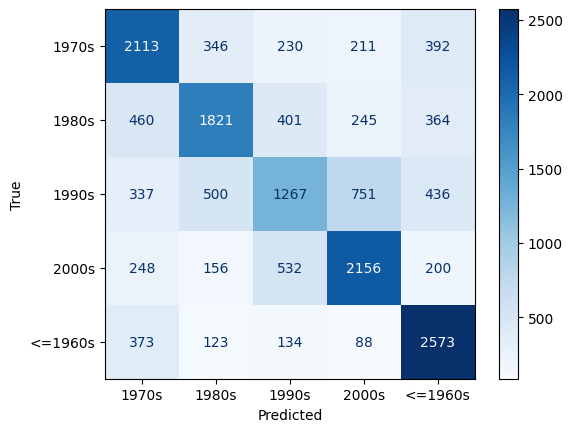

In [130]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(task_type="GPU", iterations=1000, devices='0')
cat_res = cat_model.fit(train_reduced_by_importance, train_reduced_by_importance_label) 

pred = cat_model.predict(test_reduced_by_importance)
test_label_list = test_reduced_by_importance_label.tolist()
num_right = 0

for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
#print(adjr2(train_reduced_by_importance, pred, len(train_reduced_by_importance.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_reduced_by_importance_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
test_big_label = test_big["label"].astype("category").cat.codes
test_big.drop("label", axis=1, inplace=True)

pred = cat_model.predict(test_big)
test_label_list = test_big_label.tolist()
num_right = 0
#
for i in range(len(pred)):
    if test_label_list[i] == pred[i]:
        num_right += 1

percent_right = num_right / len(pred)
print(percent_right)
#print(adjr2(test_big_label, pred, len(train.columns) - 1))

# confusion matrix
matrix = confusion_matrix(test_big_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)

labels = list(label_lookup.values())
tick_marks = np.arange(len(labels))

plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

0.5909484877493467


ValueError: Found input variables with inconsistent numbers of samples: [23510, 154604]